In [1]:
import pandas as pd
import os.path as op
import nibabel as nb
import numpy as np
import json
import trimesh
import open3d as o3d
from tools import smooth_csd
import matplotlib.pylab as plt
from matplotlib import cm, colors
from utilities import files
import tqdm.auto as tqdm
from copy import copy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.manifold import MDS

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def plot_csd(smooth_csd, list_ROI_vertices, bb_path, times, ax, cb=True):
    layer_labels = ["I", "II", "III", "IV", "V", "VI"]
    with open(bb_path, "r") as fp:
        bb = json.load(fp)
    bb = [np.array(bb[i])[list_ROI_vertices] for i in bb.keys()]
    bb_mean = [np.mean(i) for i in bb]
    bb_std = [np.std(i) for i in bb]
    max_smooth = np.max(np.abs(smooth_csd))
    divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    extent = [times[0], times[-1], 1, 0]
    csd_imshow = ax.imshow(
        smooth_csd, norm=divnorm, origin="lower",
        aspect="auto", extent=extent,
        cmap="RdBu_r"
    )
    ax.set_ylim(1,0)
    for l_ix, th in enumerate(np.cumsum(bb_mean)):
            ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
            ax.axhspan(th-bb_std[l_ix], th+bb_std[l_ix], alpha=0.05, color="black", lw=0)
            ax.annotate(layer_labels[l_ix],[times[0]+0.01, th-0.01],size=15)
    if cb:
        plt.colorbar(csd_imshow, ax=ax)
    plt.tight_layout()


In [4]:
def data_to_rgb(data, n_bins, cmap, vmin, vmax, vcenter=0, ret_map=False):
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    c = cm.ScalarMappable(divnorm, cmap=cmap)
    bins = np.histogram_bin_edges(data, bins=n_bins)
    bin_ranges = list(zip(bins[:-1], bins[1:]))
    colour_mapped = np.zeros((data.shape[0], 4))
    for br_ix, br in enumerate(bin_ranges):
        map_c = (data >= br[0]) & (data < br[1])
        colour_mapped[map_c,:] = c.to_rgba(bins[1:][br_ix])
    if not ret_map:
        return colour_mapped
    elif ret_map:
        return colour_mapped, c

In [5]:
info_path = "/home/common/bonaiuto/multiburst/derivatives/processed/sub-001/multilayer_11/info.json"
with open(info_path, "r") as fp:
    info = json.load(fp)

In [6]:
info.keys()

dict_keys(['dataset_dir', 'which_dataset', 'anatomy_dir', 'annot_paths', 'fsavg_sphere_paths', 'atlas', 'subject_info', 'freesurfer_singularity', 'big_brain_path', 'fsnat_sphere_paths', 'subject_path', 'pial', 'white', 'pial_ds', 'white_ds', 'pial_ds_nodeep', 'white_ds_nodeep', 'pial_ds_nodeep_inflated', 'multilayer', 'n_surf', 'atlas_labels_path', 'atlas_colors_path', 'cortical_thickness_path', 'big_brain_layers_path', 'sensor_epochs_paths', 'MU_paths'])

In [7]:
atlas = pd.read_csv(info["atlas"])
atlas_labels = np.load(info["atlas_colors_path"])

csd_files = files.get_files(
    op.join(info["subject_path"], "inverted"),
    "time_CSD", "npy"
)[2]

In [8]:
times = {
    "visual": np.linspace(-0.2, 0.8, num=601),
    "motor": np.linspace(-0.5, 0.5, num=601)
}

In [9]:
ROI_labels = ["L_V1_ROI", "R_V1_ROI"]
total_ix = np.arange(atlas_labels.shape[0])
ROI_vertices = {i: total_ix[[i == al.decode("utf=8") for al in atlas_labels]] for i in ROI_labels}
cds = np.load(csd_files[1])

In [10]:
true_CSD = {}
for l in ROI_labels:
    true_CSD[l] = []
    for rv in ROI_vertices[l]:
        true_CSD[l].append(cds[rv, :, :])

In [11]:
SMOOTH_CSD = {}
for l in ROI_labels:
    SMOOTH_CSD[l] = []
    for rv in ROI_vertices[l]:
        SMOOTH_CSD[l].append(smooth_csd(cds[rv, :, :], info["n_surf"]))

In [12]:
true_CSD["L_V1_ROI"][0].shape

(11, 601)

In [13]:
erp_ixs = np.where((times["visual"] >= 0) & (times["visual"] <= 0.2))[0]

In [14]:
csds = np.array([i[:, erp_ixs].flatten() for i in true_CSD["L_V1_ROI"]])

In [15]:
vertices_with_inf = np.unique(np.where(np.isinf(csds) == True)[0])

In [16]:
csds[vertices_with_inf, : ] = 0

In [17]:
scaler = RobustScaler()
ds_01 = scaler.fit_transform(csds)
pca = PCA(n_components=50)
ds_01_pca = pca.fit_transform(ds_01)

<BarContainer object of 50 artists>

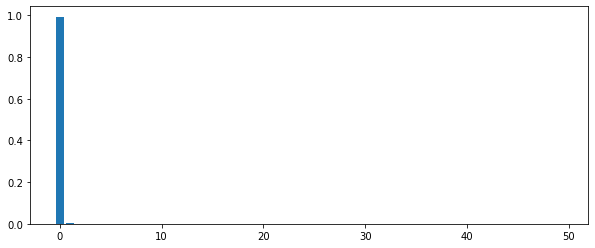

In [18]:
f, ax = plt.subplots(1, figsize=(10, 4))
ax.bar(np.arange(pca.explained_variance_ratio_.shape[0]), pca.explained_variance_ratio_)

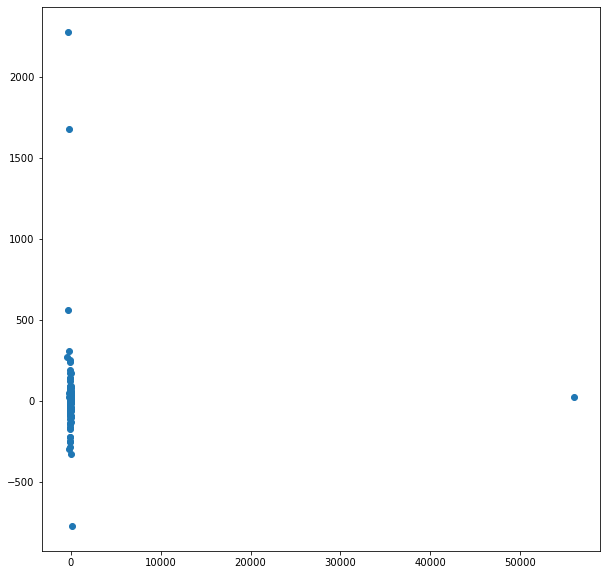

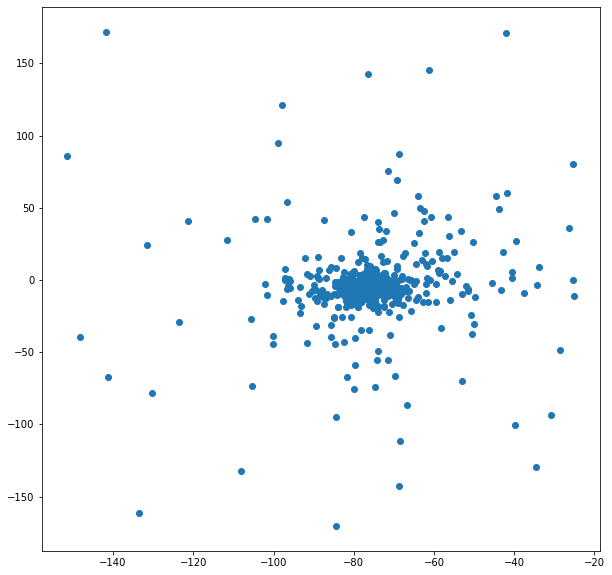

In [51]:
f, ax = plt.subplots(1, figsize=(10,10))
ax.scatter(ds_01_pca[:,0], ds_01_pca[:,1])

prc_0 = (np.percentile(ds_01_pca[:,0], 1), np.percentile(ds_01_pca[:,0], 99))
prc_0_ix = np.where((ds_01_pca[:,0] >= prc_0[0]) & (ds_01_pca[:,0] <= prc_0[1]))[0]

prc_1 = (np.percentile(ds_01_pca[:,1], 1), np.percentile(ds_01_pca[:,1], 99))
prc_1_ix = np.where((ds_01_pca[:,1] >= prc_1[0]) & (ds_01_pca[:,1] <= prc_1[1]))[0]

mask = np.ones(ds_01_pca[:,0].shape)
mask[np.intersect1d(prc_0_ix, prc_1_ix)] = 0
mask[[1,4]] = 0
mask = mask.astype(bool)
f, ax = plt.subplots(1, figsize=(10,10))
ax.scatter(ds_01_pca[:,0][~mask], ds_01_pca[:,1][~mask])

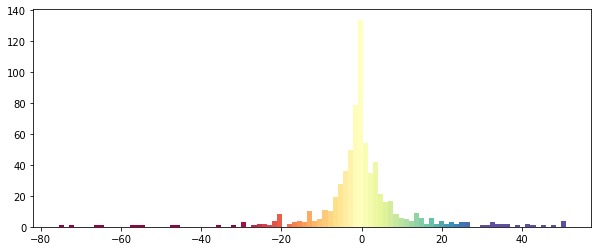

In [77]:
dt_01 = ds_01_pca[:,0][~mask] - np.mean(ds_01_pca[:,0][~mask])
n_bins = 100
x, c = data_to_rgb(dt_01, n_bins,  "Spectral", -30, 30, ret_map=True)
f, ax = plt.subplots(1, figsize=(10, 4))
hist, bins, barlist = ax.hist(dt_01, bins=n_bins)
for ix, xx in enumerate(barlist):
    plt.setp(xx, "facecolor", c.to_rgba(bins[ix+1]))

In [78]:
data_colour_map = np.repeat(np.array([[0, 1, 0.224]]), ds_01_pca[:,0].shape[0], axis=0)
data_colour_map[~mask] = x[:,:3]

In [86]:
gray = np.array([0.5, 0.5, 0.5])
brain = nb.load(info["pial_ds_nodeep_inflated"])
vertices, faces = brain.agg_data()
colours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)
for ix, v in enumerate(ROI_vertices["L_V1_ROI"]):
    colours[v] = data_colour_map[ix][:3]

# gray = np.array([0.5, 0.5, 0.5])
# brain = nb.load(info["pial_ds_nodeep"])
# vertices, faces, normals = brain.agg_data()
# colours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)
# for ix, v in enumerate(ROI_vertices["L_V1_ROI"]):
#     colours[v] = data_colour_map[ix][:3]

In [ ]:
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
mesh = mesh.as_open3d
mesh.compute_vertex_normals(normalized=True)
mesh.vertex_colors = o3d.utility.Vector3dVector(colours)
vxmask = np.array([i.decode("utf=8")[0] == "R" for i in atlas_labels]) | np.array([i.decode("utf=8")[0] == "?" for i in atlas_labels])
mesh.remove_vertices_by_mask(vxmask)
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

In [46]:
smooth_csds = np.array(SMOOTH_CSD["L_V1_ROI"])

In [ ]:
# score_pc1 = ds_01_pca[:,0] - np.mean(ds_01_pca[:,0][~mask])

# for bnd in bounds:
#     mask_s = np.where((score_pc1 >= bnd[0]) & (score_pc1 < bnd[1]))[0]
#     f, ax = plt.subplots(1, figsize=(10, 10))
#     ax.set_title("{} - {} pca score".format(*np.round(bnd, 2)))
#     cssd = np.mean(smooth_csds[mask_s], axis=0)
#     baseline = np.mean(cssd[:, np.where(times["visual"] < -0.01)], axis=2)
#     plot_csd(
#         cssd - baseline, ROI_vertices["L_V1_ROI"],
#         info["big_brain_layers_path"], times["visual"], ax
#     )

In [ ]:
pca = PCA(n_components=50)
ds_02_pca = pca.fit_transform(ds_01[~mask])